# Analiza różnic w rankigach

Analiza różnic pomiędzy:
- dokładną metodą - exact_ranking
- metodą przybliżania dla 1000 iteracji

In [2]:
import os
while "notebooks" in os.getcwd():
    os.chdir("../")


In [35]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Wczytywanie rankingów i zbioru danych

In [4]:
result_path = Path("results")
exact_ranking_data_path = result_path / "wine_exact_ranking.npy"
approx_ranking_data_path = result_path / "wine_approx_ranking_1000_iter.npy"
data_path = Path("data")
wine_test_data_path = data_path / "wine_quality/test_winequality_red_scaled.csv"

In [5]:
wine_data = pd.read_csv(wine_test_data_path)
wine_data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,-0.241094,-1.887226,0.765247,-0.666062,-0.647527,0.203223,-0.500769,-1.455778,-0.136798,0.187963,0.729364,6
1,-1.045437,-1.049255,-0.005010,0.185312,-0.434990,-0.753085,-0.075043,-1.540580,-0.655141,-0.579207,1.480302,6
2,0.103624,-1.160984,0.765247,-0.169427,-0.264960,-0.370562,-0.835267,-1.275573,-1.108690,0.305990,1.292568,7
3,-0.700719,-0.546472,0.765247,2.100902,-0.349975,1.159531,2.479310,0.293268,0.705508,0.305990,0.072294,5
4,2.229387,-0.434742,1.124700,-0.807957,-0.264960,-1.231239,-1.230584,0.081262,-1.173483,-0.166115,-0.021574,5
...,...,...,...,...,...,...,...,...,...,...,...,...
315,-0.470907,0.291499,1.484154,0.398155,1.392830,-1.039977,-0.987312,-1.052967,-0.655141,2.194408,1.104833,6
316,-0.068735,-0.993390,0.303093,-0.098479,-0.243707,-0.466193,0.016184,-0.401050,-0.266384,0.896120,0.541630,6
317,0.390889,-0.323013,0.200392,0.114364,-0.073677,0.777007,2.388083,0.876283,-0.007213,-0.284141,-0.960246,5
318,0.046171,1.045674,-0.364463,-0.098479,-0.243707,-0.561823,-0.257497,0.319768,-0.007213,-0.107102,-0.960246,5


In [6]:
exact_ranking = np.load(exact_ranking_data_path)
exact_ranking.shape

(320, 11)

In [7]:
approx_ranking_1000 = np.load(approx_ranking_data_path)

# Analiza różnic w rankingach

In [8]:
features_map = {}
for indx, name in enumerate(list(wine_data.columns.values)):
    features_map[name] = indx

In [9]:
def map_features(li: list):
    mapped_li = [features_map[i] for i in li]
    return mapped_li

In [10]:

def distance_between_lists(a, b):
    a = map_features(a)
    b = map_features(b)
    a_s = set(a)
    b_s = set(b)
    [a.append(i) for i in list(b_s-a_s)]
    [b.append(i) for i in list(a_s-b_s)]
    max_val = max(max(a), max(b))
    all_numbers_set = set(range(max_val))
    a_s = set(a)
    b_s = set(b)
    [a.append(i) for i in list(all_numbers_set - a_s)]
    [b.append(i) for i in list(all_numbers_set - b_s)]
    return cayley_distance(a, b)

def cayley_distance(x,y):
    A = range(len(x))
    inv_y = tuple(y.index(a) for a in A)
    comp = tuple(x[inv_y[a]] for a in A)
    cycles = 0
    rem = set(A)
    while rem:
        a = rem.pop()
        cycles += 1
        while comp[a] in rem:
            a = comp[a]
            rem.remove(a)
    return len(A) - cycles


## Caylel distance

### All features

In [38]:
differences_all = []
for i, j in zip(exact_ranking, approx_ranking_1000):
    diff = distance_between_lists(i, j)
    differences_all.append(diff)

In [39]:
np.mean(differences_all)

5.378125

In [40]:
np.max(differences_all)

10

In [42]:
np.min(differences_all)

0

<Axes: >

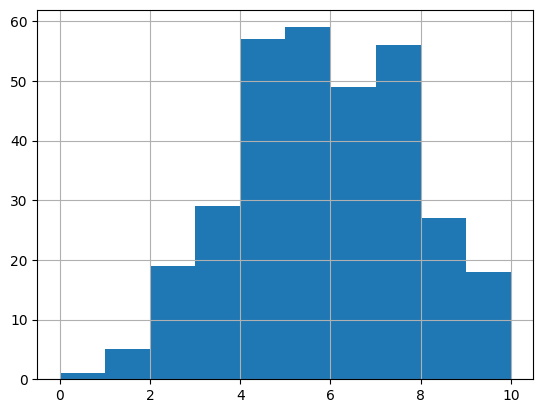

In [46]:
diff_ser = pd.Series(differences_all)
diff_ser.hist(bins=10)

In [49]:
differences_all[differences_all==10]

2

In [50]:
differences_all.index(10)

106

In [52]:
indexes = [i for i, x in enumerate(differences_all) if x == 10]
indexes


[106, 164, 184, 236]

In [57]:
print(exact_ranking[indexes[0]])
print(approx_ranking_1000[indexes[0]])

['total_sulfur_dioxide' 'density' 'citric_acid' 'free_sulfur_dioxide'
 'sulphates' 'pH' 'fixed_acidity' 'chlorides' 'alcohol' 'volatile_acidity'
 'residual_sugar']
['residual_sugar' 'chlorides' 'total_sulfur_dioxide' 'density'
 'citric_acid' 'volatile_acidity' 'alcohol' 'sulphates' 'pH'
 'free_sulfur_dioxide' 'fixed_acidity']


### Top 5 features

In [61]:
differences_5 = []
for i, j in zip(exact_ranking, approx_ranking_1000):
    i = i[0:5]
    j = j[0:5]
    diff = distance_between_lists(i, j)
    differences_5.append(diff)

In [62]:
np.mean(differences_5)

2.5375

In [63]:
np.max(differences_5)

8

In [64]:
np.min(differences_5)

0

<Axes: >

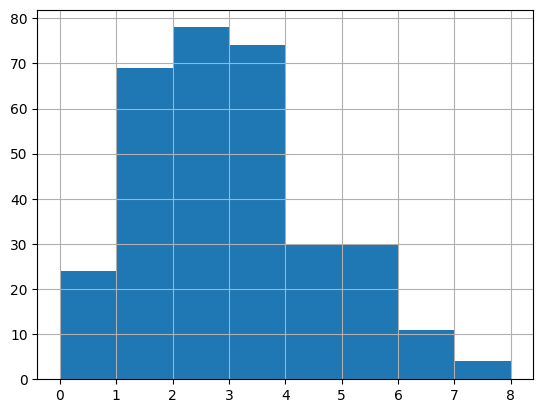

In [67]:
diff_ser = pd.Series(differences_5)
diff_ser.hist(bins=8)

In [88]:
indexes = [i for i, x in enumerate(differences_5) if x == 8]
indexes


[319]

In [89]:
print(exact_ranking[indexes[0]])
print(approx_ranking_1000[indexes[0]])

['pH' 'residual_sugar' 'sulphates' 'alcohol' 'density' 'volatile_acidity'
 'fixed_acidity' 'citric_acid' 'chlorides' 'total_sulfur_dioxide'
 'free_sulfur_dioxide']
['chlorides' 'sulphates' 'volatile_acidity' 'total_sulfur_dioxide'
 'free_sulfur_dioxide' 'pH' 'density' 'citric_acid' 'fixed_acidity'
 'residual_sugar' 'alcohol']


### Top 3 features

In [90]:
differences_3 = []
for i, j in zip(exact_ranking, approx_ranking_1000):
    i = i[0:3]
    j = j[0:3]
    diff = distance_between_lists(i, j)
    differences_3.append(diff)

In [91]:
np.mean(differences_3)

1.1875

In [92]:
np.max(differences_3)

5

In [93]:
np.min(differences_3)

0

<Axes: >

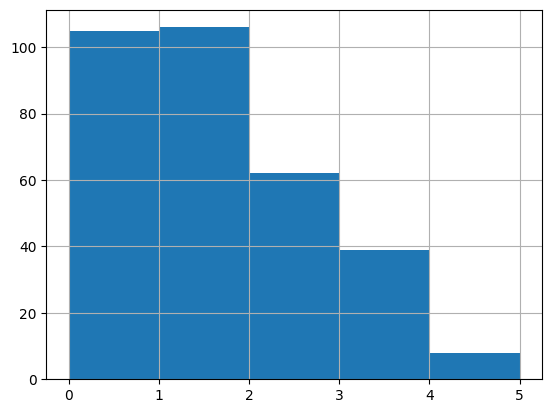

In [94]:
diff_ser = pd.Series(differences_3)
diff_ser.hist(bins=5)

In [95]:
indexes = [i for i, x in enumerate(differences_3) if x == 3]
indexes


[33,
 40,
 51,
 54,
 69,
 70,
 93,
 101,
 105,
 106,
 108,
 112,
 127,
 140,
 143,
 147,
 151,
 164,
 178,
 179,
 183,
 184,
 205,
 217,
 218,
 228,
 236,
 240,
 246,
 252,
 263,
 264,
 269,
 272,
 284,
 290,
 295,
 302,
 308]

In [96]:
print(exact_ranking[indexes[0]])
print(approx_ranking_1000[indexes[0]])

['pH' 'chlorides' 'total_sulfur_dioxide' 'volatile_acidity'
 'residual_sugar' 'citric_acid' 'density' 'fixed_acidity'
 'free_sulfur_dioxide' 'sulphates' 'alcohol']
['sulphates' 'alcohol' 'residual_sugar' 'total_sulfur_dioxide'
 'volatile_acidity' 'pH' 'chlorides' 'citric_acid' 'density'
 'fixed_acidity' 'free_sulfur_dioxide']


## Diffrence between sets

In [102]:
def set_difference(a, b):
    a_s = set(a)
    b_s = set(b)
    diff = a_s.difference(b_s) 
    return len(diff)

### Top 5 features

In [109]:
set_differences_5 = []
for i, j in zip(exact_ranking, approx_ranking_1000):
    i = i[0:5]
    j = j[0:5]
    diff = set_difference(i, j)
    set_differences_5.append(diff)

In [112]:
np.mean(set_differences_5)

1.06875

In [113]:
np.max(set_differences_5)

4

In [114]:
np.min(set_differences_5)

0

<Axes: >

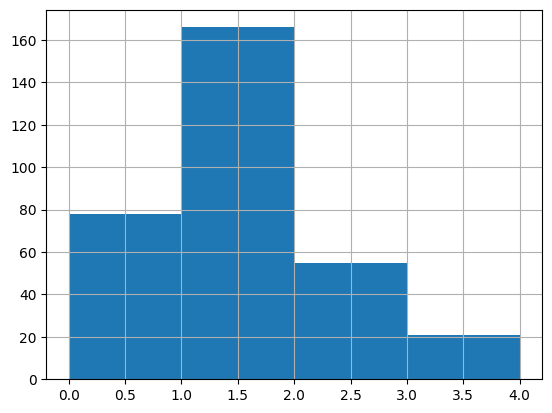

In [115]:
diff_ser = pd.Series(set_differences_5)
diff_ser.hist(bins=4)

In [117]:
indexes = [i for i, x in enumerate(set_differences_5) if x == 4]
indexes


[151, 183, 319]

In [118]:
print(exact_ranking[indexes[0]])
print(approx_ranking_1000[indexes[0]])

['residual_sugar' 'chlorides' 'pH' 'total_sulfur_dioxide'
 'free_sulfur_dioxide' 'fixed_acidity' 'volatile_acidity' 'citric_acid'
 'alcohol' 'sulphates' 'density']
['alcohol' 'residual_sugar' 'volatile_acidity' 'sulphates' 'citric_acid'
 'pH' 'free_sulfur_dioxide' 'fixed_acidity' 'density'
 'total_sulfur_dioxide' 'chlorides']


### Top 3 features

In [119]:
set_differences_3 = []
for i, j in zip(exact_ranking, approx_ranking_1000):
    i = i[0:3]
    j = j[0:3]
    diff = set_difference(i, j)
    set_differences_3.append(diff)

In [120]:
np.mean(set_differences_3)

0.675

In [121]:
np.max(set_differences_3)

3

In [122]:
np.min(set_differences_3)

0

<Axes: >

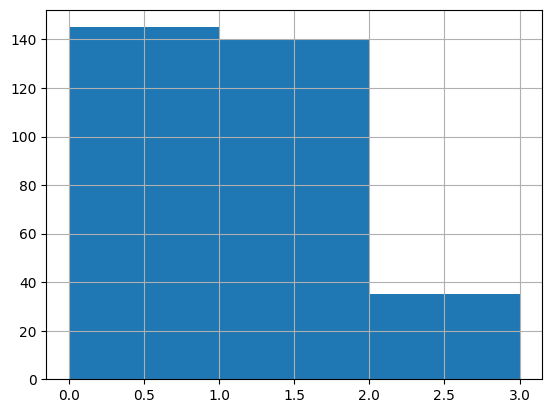

In [125]:
diff_ser = pd.Series(set_differences_3)
diff_ser.hist(bins=3)

In [127]:
indexes = [i for i, x in enumerate(set_differences_3) if x == 3]
indexes


[33, 178, 183, 233, 293, 308]

In [128]:
print(exact_ranking[indexes[0]])
print(approx_ranking_1000[indexes[0]])

['pH' 'chlorides' 'total_sulfur_dioxide' 'volatile_acidity'
 'residual_sugar' 'citric_acid' 'density' 'fixed_acidity'
 'free_sulfur_dioxide' 'sulphates' 'alcohol']
['sulphates' 'alcohol' 'residual_sugar' 'total_sulfur_dioxide'
 'volatile_acidity' 'pH' 'chlorides' 'citric_acid' 'density'
 'fixed_acidity' 'free_sulfur_dioxide']
